这个记事本用来生成一些背景样本。因为我推测loss降不下去以及模型总是预测出问题就是这个导致的

做法：定义一个new-target，这个new-target相较于之前的target的改进是：添加样本类别方面的信息并且包含随机的负样本，即背景样本

另外，这个新的target要改进之前的数据集中的一个bug：之前的数据集中，target都是"x, y, w, h"格式，现在改成"x1, y1, x2, y2"格式

In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import torch
from utils import *
from torch.utils.data import DataLoader
import random
from random import randint

In [2]:
dataset = SegDataset('IAM', 'train')
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

for i, data in enumerate(dataloader):
    image, target = data
    print(image.shape, target.shape)
    break

/root/autodl-tmp/APS360_Project/Data_Preprocessing/utils.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data = torch.load(os.path.join(self.path, 'seg_data_' + mo

torch.Size([1, 1, 1024, 1024]) torch.Size([1, 256, 4])


/root/autodl-tmp/APS360_Project/Data_Preprocessing/utils.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.label = torch.load(os.path.join(self.path, 'seg_label_' + 

定义一个有关类别的数据

In [3]:
ones = target.sum(dim=-1) != 0
labels = torch.zeros_like(ones, dtype=torch.long)
labels[ones] = 1
labels

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

接下来生成随机的框框代表背景。前提是框框不能和正样本有交集，并且不能和其他背景样本有交集

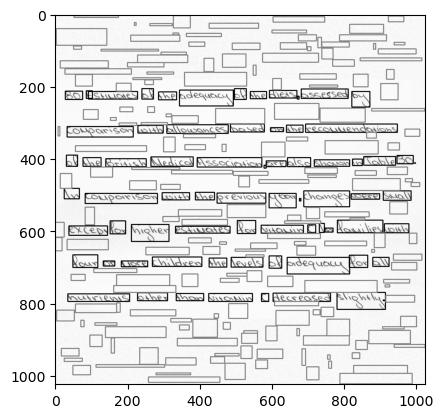

In [4]:
def inside_box(box, targets):
    x1, y1, x2, y2 = box
    for target in targets:
        t_x1, t_y1, t_x2, t_y2 = target
        # 检测是否有交集
        if not (x2 <= t_x1 or x1 >= t_x2 or y2 <= t_y1 or y1 >= t_y2):
            return True
    return False

def get_random_box(targets):
    """
    生成一个随机的box，确保box不和任何已有的box重叠
    """
    # image size固定式1024x1024，直接hard code
    while True:
        w, h = randint(5, 200), randint(5, 50)
        x, y = randint(0, 1024-w), randint(0, 1024-h)
        if not inside_box((x, y, x+w, y+h), targets):
            return (x, y, x+w, y+h)

def get_random_boxes(targets, ones):
    # targets shape: 256, 4
    start_index = ones.sum().item()
    for i in range(start_index, targets.shape[0]):
        targets[i, :] = torch.tensor(get_random_box(targets[:i, :]))
    return targets


for i, data in enumerate(dataloader):
    image, target = data
    image, target = image[0], target[0]
    target[:, 2] += target[:, 0]
    target[:, 3] += target[:, 1]
    break

ones = target.sum(dim=-1) != 0
labels = torch.zeros_like(ones, dtype=torch.long)
labels[ones] = 1

target = get_random_boxes(target.clone(), ones)
# 给图片加上bounding box，正样本使用黑色，负样本使用灰色
image = image.squeeze().numpy()
for i in range(target.shape[0]):
    x1, y1, x2, y2 = target[i].int().numpy()
    # print(x1, y1, x2, y2)
    if labels[i] == 1:
        cv2.rectangle(image, (x1, y1), (x2, y2), (0), 2)
    else:
        cv2.rectangle(image, (x1, y1), (x2, y2), (128), 2)
plt.imshow(image, cmap='gray')

将所有数据加载，保存到一个新的pt文件中

In [10]:
def modify_dataset(name, mode):
    dataset = SegDataset(name, mode)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
    new_target = {'boxes': [], 'labels': []}
    for i, data in enumerate(dataloader):
        image, target = data
        image, target = image[0], target[0]
        target[:, 2] += target[:, 0]
        target[:, 3] += target[:, 1]
        ones = target.sum(dim=-1) != 0
        labels = torch.zeros_like(ones, dtype=torch.long)
        labels[ones] = 1
        target = get_random_boxes(target.clone(), ones)
        new_target['boxes'].append(target)
        new_target['labels'].append(labels)
        path = f"/root/autodl-tmp/APS360_Project/Datasets/{name}_Processed/seg_label_{mode}_new.pt"
        print(f"\rProcessed {i} images", end='')
    torch.save(new_target, path)

modify_dataset('IAM', 'test')
modify_dataset('CVL', 'train')
modify_dataset('CVL', 'val')
modify_dataset('CVL', 'test')

/root/autodl-tmp/APS360_Project/Data_Preprocessing/utils.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data = torch.load(os.path.join(self.path, 'seg_data_' + mo

Processed 159 imagess

In [ ]:
# 定义新的dataset类

class SegDatasetNew(SegDataset):
    def __init__(self, name, mode):
        super(SegDatasetNew, self).__init__(name, mode)
        IAM_path = "/root/autodl-tmp/APS360_Project/Datasets/IAM_Processed"
        CVL_path = "/root/autodl-tmp/APS360_Project/Datasets/CVL_Processed"
        if name == 'IAM':
            self.path = IAM_path
        elif name == 'CVL':
            self.path = CVL_path
        else:
            raise ValueError("Invalid dataset name")
        self.name = name
        self.mode = mode
        self.data = torch.load(f"{self.path}/seg_data_{mode}_new.pt")
        self.target = torch.load(f"{self.path}/seg_label_{mode}_new.pt")
        self.length = len(self.data)
    
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        # make sure that the image is in 0-1 range
        image = self.data[idx]
        image -= image.min()
        image /= image.max()
        target = self.target['boxes'][idx]
        labels = self.target['labels'][idx]
        return image, (target, labels)

dataset = SegDatasetNew('IAM', 'train')
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
for i, data in enumerate(dataloader):
    image, target = data
    image, target = image[0], target[0]
    boxes, labels = target
    break
print(boxes, labels)